In [1]:
# %%
%load_ext autoreload
%autoreload 2

In [23]:
# %% imports
import pandas as pd
import numpy as np
from scripts.signals import Signal, MeanReversion, CrossSectionCorrelation, BetaResidual
from scripts.filters import VolumeFilter, FixedVolumeFilter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# %% loading data
raw_data = pd.read_csv('../data/data_f2009.csv', parse_dates=['date']).set_index(['date', 'ticker'])
data = raw_data.sort_index()

In [17]:
datasample = data.loc[:"2013-12-19"]

In [18]:
datasample.head()

adj_volume  adj_close  future_perf_1d  past_perf_1d
date       ticker                                                      
2009-01-05 A       5129700.000  11.454821        0.079809      0.033867
           AAL     3457100.145  21.644190        0.087635     -0.007151
           AAN        2500.500  14.233812        0.050228      0.025761
           AAON    1258399.125   5.626286       -0.001433      0.002395
           AAP      969700.000  32.795583        0.001485     -0.013474

In [25]:
br = BetaResidual(datasample, past=False, rolling_window=200)
datasample['betaResidualsFuturePerf'] = br.get_signal()

/Users/marc/.miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [26]:
# Because WAG is now WBA
datasample.drop("WAG", axis=0, level=1, inplace=True)

/Users/marc/.miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [27]:
# %% filter data
nb_stocks = 200
datasample['filter'] = FixedVolumeFilter(datasample, nb_stocks, "2009-01-05").get_filter()

/Users/marc/.miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/marc/.miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [28]:
kept_tickers = sorted(datasample["filter"].loc(axis=0)[datasample["filter"] == 1].index.get_level_values(1).unique())

In [29]:
# %% create signal 
# ---- 
# note that we need more n_past than number of kept stocks if we want
# the correlation matric to be non-singular. 
# We need to put lots of n_past days in order for GARCH models to converge. 
mr_signal = CrossSectionCorrelation(datasample, n_past=200, n_fit=3, refit=30)

# %lprun -f mr_signal._compute datasample['signal'] = mr_signal.get_signal()
# %load_ext line_profiler

datasample['signal'] = mr_signal.get_signal()

2009-10-23 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -1.815226727138768e-16

2009-10-26 00:00:00
2009-10-27 00:00:00
2009-10-28 00:00:00
2009-10-29 00:00:00
2009-10-30 00:00:00
2009-11-02 00:00:00
2009-11-03 00:00:00
2009-11-04 00:00:00
2009-11-05 00:00:00
2009-11-06 00:00:00
2009-11-09 00:00:00
2009-11-10 00:00:00
2009-11-11 00:00:00
2009-11-12 00:00:00
2009-11-13 00:00:00
2009-11-16 00:00:00
2009-11-17 00:00:00
2009-11-18 00:00:00
2009-11-19 00:00:00
2009-11-20 00:00:00
2009-11-23 00:00:00
2009-11-24 00:00:00
2009-11-25 00:00:00
2009-11-27 00:00:00
2009-11-30 00:00:00
2009-12-01 00:00:00
2009-12-02 00:00:00
2009-12-03 00:00:00
2009-12-04 00:00:00
2009-12-07 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -6.998885012396514e-16
2009-12-08 00:00:00
2009-12-09 00:00:00
2009-12-10 00:00:00
2009-12-11 00:00:00
2009-12-14 00:00:00
2009-12-15 00:00:00
2009-12-16 00:00:00
2009-12-17 00:00:00
2009-12-18 00:00:00
2009-12-21 00:00:00
2009-12-22 00:00:00
2009-12-23 00:00:00
2009-12-24 00:00:00
2009-12-28 00:00:00
2009-12-29 00:00:00
2009-12-30 00:00:00
2009-12-31 00:00:00
2010-01-04 00:00:00
2010-01-05 00:00:00
2010-01-06 00:00:00
2010-01-07 00:00:00
2010-01-08 00:00:00
2010-01-11 00:00:00
2010-01-12 00:00:00
2010-01-13 00:00:00
2010-01-14 00:00:00
2010-01-15 00:00:00
2010-01-19 00:00:00
2010-01-20 00:00:00
2010-01-21 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 3.2268163191776667e-16
2010-01-22 00:00:00
2010-01-25 00:00:00
2010-01-26 00:00:00
2010-01-27 00:00:00
2010-01-28 00:00:00
2010-01-29 00:00:00
2010-02-01 00:00:00
2010-02-02 00:00:00
2010-02-03 00:00:00
2010-02-04 00:00:00
2010-02-05 00:00:00
2010-02-08 00:00:00
2010-02-09 00:00:00
2010-02-10 00:00:00
2010-02-11 00:00:00
2010-02-12 00:00:00
2010-02-16 00:00:00
2010-02-17 00:00:00
2010-02-18 00:00:00
2010-02-19 00:00:00
2010-02-22 00:00:00
2010-02-23 00:00:00
2010-02-24 00:00:00
2010-02-25 00:00:00
2010-02-26 00:00:00
2010-03-01 00:00:00
2010-03-02 00:00:00
2010-03-03 00:00:00
2010-03-04 00:00:00
2010-03-05 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 1.9682989087992753e-16
2010-03-08 00:00:00
2010-03-09 00:00:00
2010-03-10 00:00:00
2010-03-11 00:00:00
2010-03-12 00:00:00
2010-03-15 00:00:00
2010-03-16 00:00:00
2010-03-17 00:00:00
2010-03-18 00:00:00
2010-03-19 00:00:00
2010-03-22 00:00:00
2010-03-23 00:00:00
2010-03-24 00:00:00
2010-03-25 00:00:00
2010-03-26 00:00:00
2010-03-29 00:00:00
2010-03-30 00:00:00
2010-03-31 00:00:00
2010-04-01 00:00:00
2010-04-05 00:00:00
2010-04-06 00:00:00
2010-04-07 00:00:00
2010-04-08 00:00:00
2010-04-09 00:00:00
2010-04-12 00:00:00
2010-04-13 00:00:00
2010-04-14 00:00:00
2010-04-15 00:00:00
2010-04-16 00:00:00
2010-04-19 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -3.8222035347439045e-16
2010-04-20 00:00:00
2010-04-21 00:00:00
2010-04-22 00:00:00
2010-04-23 00:00:00
2010-04-26 00:00:00
2010-04-27 00:00:00
2010-04-28 00:00:00
2010-04-29 00:00:00
2010-04-30 00:00:00
2010-05-03 00:00:00
2010-05-04 00:00:00
2010-05-05 00:00:00
2010-05-06 00:00:00
2010-05-07 00:00:00
2010-05-10 00:00:00
2010-05-11 00:00:00
2010-05-12 00:00:00
2010-05-13 00:00:00
2010-05-14 00:00:00
2010-05-17 00:00:00
2010-05-18 00:00:00
2010-05-19 00:00:00
2010-05-20 00:00:00
2010-05-21 00:00:00
2010-05-24 00:00:00
2010-05-25 00:00:00
2010-05-26 00:00:00
2010-05-27 00:00:00
2010-05-28 00:00:00
2010-06-01 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -5.824251465846878e-16
2010-06-02 00:00:00
2010-06-03 00:00:00
2010-06-04 00:00:00
2010-06-07 00:00:00
2010-06-08 00:00:00
2010-06-09 00:00:00
2010-06-10 00:00:00
2010-06-11 00:00:00
2010-06-14 00:00:00
2010-06-15 00:00:00
2010-06-16 00:00:00
2010-06-17 00:00:00
2010-06-18 00:00:00
2010-06-21 00:00:00
2010-06-22 00:00:00
2010-06-23 00:00:00
2010-06-24 00:00:00
2010-06-25 00:00:00
2010-06-28 00:00:00
2010-06-29 00:00:00
2010-06-30 00:00:00
2010-07-01 00:00:00
2010-07-02 00:00:00
2010-07-06 00:00:00
2010-07-07 00:00:00
2010-07-08 00:00:00
2010-07-09 00:00:00
2010-07-12 00:00:00
2010-07-13 00:00:00
2010-07-14 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -6.020895966502754e-16
2010-07-15 00:00:00
2010-07-16 00:00:00
2010-07-19 00:00:00
2010-07-20 00:00:00
2010-07-21 00:00:00
2010-07-22 00:00:00
2010-07-23 00:00:00
2010-07-26 00:00:00
2010-07-27 00:00:00
2010-07-28 00:00:00
2010-07-29 00:00:00
2010-07-30 00:00:00
2010-08-02 00:00:00
2010-08-03 00:00:00
2010-08-04 00:00:00
2010-08-05 00:00:00
2010-08-06 00:00:00
2010-08-09 00:00:00
2010-08-10 00:00:00
2010-08-11 00:00:00
2010-08-12 00:00:00
2010-08-13 00:00:00
2010-08-16 00:00:00
2010-08-17 00:00:00
2010-08-18 00:00:00
2010-08-19 00:00:00
2010-08-20 00:00:00
2010-08-23 00:00:00
2010-08-24 00:00:00
2010-08-25 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -4.625368076222608e-16
2010-08-26 00:00:00
2010-08-27 00:00:00
2010-08-30 00:00:00
2010-08-31 00:00:00
2010-09-01 00:00:00
2010-09-02 00:00:00
2010-09-03 00:00:00
2010-09-07 00:00:00
2010-09-08 00:00:00
2010-09-09 00:00:00
2010-09-10 00:00:00
2010-09-13 00:00:00
2010-09-14 00:00:00
2010-09-15 00:00:00
2010-09-16 00:00:00
2010-09-17 00:00:00
2010-09-20 00:00:00
2010-09-21 00:00:00
2010-09-22 00:00:00
2010-09-23 00:00:00
2010-09-24 00:00:00
2010-09-27 00:00:00
2010-09-28 00:00:00
2010-09-29 00:00:00
2010-09-30 00:00:00
2010-10-01 00:00:00
2010-10-04 00:00:00
2010-10-05 00:00:00
2010-10-06 00:00:00
2010-10-07 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 3.3444047790621947e-16
2010-10-08 00:00:00
2010-10-11 00:00:00
2010-10-12 00:00:00
2010-10-13 00:00:00
2010-10-14 00:00:00
2010-10-15 00:00:00
2010-10-18 00:00:00
2010-10-19 00:00:00
2010-10-20 00:00:00
2010-10-21 00:00:00
2010-10-22 00:00:00
2010-10-25 00:00:00
2010-10-26 00:00:00
2010-10-27 00:00:00
2010-10-28 00:00:00
2010-10-29 00:00:00
2010-11-01 00:00:00
2010-11-02 00:00:00
2010-11-03 00:00:00
2010-11-04 00:00:00
2010-11-05 00:00:00
2010-11-08 00:00:00
2010-11-09 00:00:00
2010-11-10 00:00:00
2010-11-11 00:00:00
2010-11-12 00:00:00
2010-11-15 00:00:00
2010-11-16 00:00:00
2010-11-17 00:00:00
2010-11-18 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -1.0390459194809209e-16
2010-11-19 00:00:00
2010-11-22 00:00:00
2010-11-23 00:00:00
2010-11-24 00:00:00
2010-11-26 00:00:00
2010-11-29 00:00:00
2010-11-30 00:00:00
2010-12-01 00:00:00
2010-12-02 00:00:00
2010-12-03 00:00:00
2010-12-06 00:00:00
2010-12-07 00:00:00
2010-12-08 00:00:00
2010-12-09 00:00:00
2010-12-10 00:00:00
2010-12-13 00:00:00
2010-12-14 00:00:00
2010-12-15 00:00:00
2010-12-16 00:00:00
2010-12-17 00:00:00
2010-12-20 00:00:00
2010-12-21 00:00:00
2010-12-22 00:00:00
2010-12-23 00:00:00
2010-12-27 00:00:00
2010-12-28 00:00:00
2010-12-29 00:00:00
2010-12-30 00:00:00
2010-12-31 00:00:00
2011-01-03 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -5.258357336680961e-16
2011-01-04 00:00:00
2011-01-05 00:00:00
2011-01-06 00:00:00
2011-01-07 00:00:00
2011-01-10 00:00:00
2011-01-11 00:00:00
2011-01-12 00:00:00
2011-01-13 00:00:00
2011-01-14 00:00:00
2011-01-18 00:00:00
2011-01-19 00:00:00
2011-01-20 00:00:00
2011-01-21 00:00:00
2011-01-24 00:00:00
2011-01-25 00:00:00
2011-01-26 00:00:00
2011-01-27 00:00:00
2011-01-28 00:00:00
2011-01-31 00:00:00
2011-02-01 00:00:00
2011-02-02 00:00:00
2011-02-03 00:00:00
2011-02-04 00:00:00
2011-02-07 00:00:00
2011-02-08 00:00:00
2011-02-09 00:00:00
2011-02-10 00:00:00
2011-02-11 00:00:00
2011-02-14 00:00:00
2011-02-15 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -9.771015427183093e-16
2011-02-16 00:00:00
2011-02-17 00:00:00
2011-02-18 00:00:00
2011-02-22 00:00:00
2011-02-23 00:00:00
2011-02-24 00:00:00
2011-02-25 00:00:00
2011-02-28 00:00:00
2011-03-01 00:00:00
2011-03-02 00:00:00
2011-03-03 00:00:00
2011-03-04 00:00:00
2011-03-07 00:00:00
2011-03-08 00:00:00
2011-03-09 00:00:00
2011-03-10 00:00:00
2011-03-11 00:00:00
2011-03-14 00:00:00
2011-03-15 00:00:00
2011-03-16 00:00:00
2011-03-17 00:00:00
2011-03-18 00:00:00
2011-03-21 00:00:00
2011-03-22 00:00:00
2011-03-23 00:00:00
2011-03-24 00:00:00
2011-03-25 00:00:00
2011-03-28 00:00:00
2011-03-29 00:00:00
2011-03-30 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -6.989843827343104e-17
2011-03-31 00:00:00
2011-04-01 00:00:00
2011-04-04 00:00:00
2011-04-05 00:00:00
2011-04-06 00:00:00
2011-04-07 00:00:00
2011-04-08 00:00:00
2011-04-11 00:00:00
2011-04-12 00:00:00
2011-04-13 00:00:00
2011-04-14 00:00:00
2011-04-15 00:00:00
2011-04-18 00:00:00
2011-04-19 00:00:00
2011-04-20 00:00:00
2011-04-21 00:00:00
2011-04-25 00:00:00
2011-04-26 00:00:00
2011-04-27 00:00:00
2011-04-28 00:00:00
2011-04-29 00:00:00
2011-05-02 00:00:00
2011-05-03 00:00:00
2011-05-04 00:00:00
2011-05-05 00:00:00
2011-05-06 00:00:00
2011-05-09 00:00:00
2011-05-10 00:00:00
2011-05-11 00:00:00
2011-05-12 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 1.0676999295400498e-16
2011-05-13 00:00:00
2011-05-16 00:00:00
2011-05-17 00:00:00
2011-05-18 00:00:00
2011-05-19 00:00:00
2011-05-20 00:00:00
2011-05-23 00:00:00
2011-05-24 00:00:00
2011-05-25 00:00:00
2011-05-26 00:00:00
2011-05-27 00:00:00
2011-05-31 00:00:00
2011-06-01 00:00:00
2011-06-02 00:00:00
2011-06-03 00:00:00
2011-06-06 00:00:00
2011-06-07 00:00:00
2011-06-08 00:00:00
2011-06-09 00:00:00
2011-06-10 00:00:00
2011-06-13 00:00:00
2011-06-14 00:00:00
2011-06-15 00:00:00
2011-06-16 00:00:00
2011-06-17 00:00:00
2011-06-20 00:00:00
2011-06-21 00:00:00
2011-06-22 00:00:00
2011-06-23 00:00:00
2011-06-24 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 4.079055758625017e-16
2011-06-27 00:00:00
2011-06-28 00:00:00
2011-06-29 00:00:00
2011-06-30 00:00:00
2011-07-01 00:00:00
2011-07-05 00:00:00
2011-07-06 00:00:00
2011-07-07 00:00:00
2011-07-08 00:00:00
2011-07-11 00:00:00
2011-07-12 00:00:00
2011-07-13 00:00:00
2011-07-14 00:00:00
2011-07-15 00:00:00
2011-07-18 00:00:00
2011-07-19 00:00:00
2011-07-20 00:00:00
2011-07-21 00:00:00
2011-07-22 00:00:00
2011-07-25 00:00:00
2011-07-26 00:00:00
2011-07-27 00:00:00
2011-07-28 00:00:00
2011-07-29 00:00:00
2011-08-01 00:00:00
2011-08-02 00:00:00
2011-08-03 00:00:00
2011-08-04 00:00:00
2011-08-05 00:00:00
2011-08-08 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -6.150085110897606e-17
2011-08-09 00:00:00
2011-08-10 00:00:00
2011-08-11 00:00:00
2011-08-12 00:00:00
2011-08-15 00:00:00
2011-08-16 00:00:00
2011-08-17 00:00:00
2011-08-18 00:00:00
2011-08-19 00:00:00
2011-08-22 00:00:00
2011-08-23 00:00:00
2011-08-24 00:00:00
2011-08-25 00:00:00
2011-08-26 00:00:00
2011-08-29 00:00:00
2011-08-30 00:00:00
2011-08-31 00:00:00
2011-09-01 00:00:00
2011-09-02 00:00:00
2011-09-06 00:00:00
2011-09-07 00:00:00
2011-09-08 00:00:00
2011-09-09 00:00:00
2011-09-12 00:00:00
2011-09-13 00:00:00
2011-09-14 00:00:00
2011-09-15 00:00:00
2011-09-16 00:00:00
2011-09-19 00:00:00
2011-09-20 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 1.2555926478966754e-17
2011-09-21 00:00:00
2011-09-22 00:00:00
2011-09-23 00:00:00
2011-09-26 00:00:00
2011-09-27 00:00:00
2011-09-28 00:00:00
2011-09-29 00:00:00
2011-09-30 00:00:00
2011-10-03 00:00:00
2011-10-04 00:00:00
2011-10-05 00:00:00
2011-10-06 00:00:00
2011-10-07 00:00:00
2011-10-10 00:00:00
2011-10-11 00:00:00
2011-10-12 00:00:00
2011-10-13 00:00:00
2011-10-14 00:00:00
2011-10-17 00:00:00
2011-10-18 00:00:00
2011-10-19 00:00:00
2011-10-20 00:00:00
2011-10-21 00:00:00
2011-10-24 00:00:00
2011-10-25 00:00:00
2011-10-26 00:00:00
2011-10-27 00:00:00
2011-10-28 00:00:00
2011-10-31 00:00:00
2011-11-01 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 2.442710140295177e-16
2011-11-02 00:00:00
2011-11-03 00:00:00
2011-11-04 00:00:00
2011-11-07 00:00:00
2011-11-08 00:00:00
2011-11-09 00:00:00
2011-11-10 00:00:00
2011-11-11 00:00:00
2011-11-14 00:00:00
2011-11-15 00:00:00
2011-11-16 00:00:00
2011-11-17 00:00:00
2011-11-18 00:00:00
2011-11-21 00:00:00
2011-11-22 00:00:00
2011-11-23 00:00:00
2011-11-25 00:00:00
2011-11-28 00:00:00
2011-11-29 00:00:00
2011-11-30 00:00:00
2011-12-01 00:00:00
2011-12-02 00:00:00
2011-12-05 00:00:00
2011-12-06 00:00:00
2011-12-07 00:00:00
2011-12-08 00:00:00
2011-12-09 00:00:00
2011-12-12 00:00:00
2011-12-13 00:00:00
2011-12-14 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 5.622926360058292e-16
2011-12-15 00:00:00
2011-12-16 00:00:00
2011-12-19 00:00:00
2011-12-20 00:00:00
2011-12-21 00:00:00
2011-12-22 00:00:00
2011-12-23 00:00:00
2011-12-27 00:00:00
2011-12-28 00:00:00
2011-12-29 00:00:00
2011-12-30 00:00:00
2012-01-03 00:00:00
2012-01-04 00:00:00
2012-01-05 00:00:00
2012-01-06 00:00:00
2012-01-09 00:00:00
2012-01-10 00:00:00
2012-01-11 00:00:00
2012-01-12 00:00:00
2012-01-13 00:00:00
2012-01-17 00:00:00
2012-01-18 00:00:00
2012-01-19 00:00:00
2012-01-20 00:00:00
2012-01-23 00:00:00
2012-01-24 00:00:00
2012-01-25 00:00:00
2012-01-26 00:00:00
2012-01-27 00:00:00
2012-01-30 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -2.418460749770086e-16
2012-01-31 00:00:00
2012-02-01 00:00:00
2012-02-02 00:00:00
2012-02-03 00:00:00
2012-02-06 00:00:00
2012-02-07 00:00:00
2012-02-08 00:00:00
2012-02-09 00:00:00
2012-02-10 00:00:00
2012-02-13 00:00:00
2012-02-14 00:00:00
2012-02-15 00:00:00
2012-02-16 00:00:00
2012-02-17 00:00:00
2012-02-21 00:00:00
2012-02-22 00:00:00
2012-02-23 00:00:00
2012-02-24 00:00:00
2012-02-27 00:00:00
2012-02-28 00:00:00
2012-02-29 00:00:00
2012-03-01 00:00:00
2012-03-02 00:00:00
2012-03-05 00:00:00
2012-03-06 00:00:00
2012-03-07 00:00:00
2012-03-08 00:00:00
2012-03-09 00:00:00
2012-03-12 00:00:00
2012-03-13 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -1.0254953746024027e-15
2012-03-14 00:00:00
2012-03-15 00:00:00
2012-03-16 00:00:00
2012-03-19 00:00:00
2012-03-20 00:00:00
2012-03-21 00:00:00
2012-03-22 00:00:00
2012-03-23 00:00:00
2012-03-26 00:00:00
2012-03-27 00:00:00
2012-03-28 00:00:00
2012-03-29 00:00:00
2012-03-30 00:00:00
2012-04-02 00:00:00
2012-04-03 00:00:00
2012-04-04 00:00:00
2012-04-05 00:00:00
2012-04-09 00:00:00
2012-04-10 00:00:00
2012-04-11 00:00:00
2012-04-12 00:00:00
2012-04-13 00:00:00
2012-04-16 00:00:00
2012-04-17 00:00:00
2012-04-18 00:00:00
2012-04-19 00:00:00
2012-04-20 00:00:00
2012-04-23 00:00:00
2012-04-24 00:00:00
2012-04-25 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -4.9594199643414364e-17
2012-04-26 00:00:00
2012-04-27 00:00:00
2012-04-30 00:00:00
2012-05-01 00:00:00
2012-05-02 00:00:00
2012-05-03 00:00:00
2012-05-04 00:00:00
2012-05-07 00:00:00
2012-05-08 00:00:00
2012-05-09 00:00:00
2012-05-10 00:00:00
2012-05-11 00:00:00
2012-05-14 00:00:00
2012-05-15 00:00:00
2012-05-16 00:00:00
2012-05-17 00:00:00
2012-05-18 00:00:00
2012-05-21 00:00:00
2012-05-22 00:00:00
2012-05-23 00:00:00
2012-05-24 00:00:00
2012-05-25 00:00:00
2012-05-29 00:00:00
2012-05-30 00:00:00
2012-05-31 00:00:00
2012-06-01 00:00:00
2012-06-04 00:00:00
2012-06-05 00:00:00
2012-06-06 00:00:00
2012-06-07 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -9.51636689671581e-16
2012-06-08 00:00:00
2012-06-11 00:00:00
2012-06-12 00:00:00
2012-06-13 00:00:00
2012-06-14 00:00:00
2012-06-15 00:00:00
2012-06-18 00:00:00
2012-06-19 00:00:00
2012-06-20 00:00:00
2012-06-21 00:00:00
2012-06-22 00:00:00
2012-06-25 00:00:00
2012-06-26 00:00:00
2012-06-27 00:00:00
2012-06-28 00:00:00
2012-06-29 00:00:00
2012-07-02 00:00:00
2012-07-03 00:00:00
2012-07-05 00:00:00
2012-07-06 00:00:00
2012-07-09 00:00:00
2012-07-10 00:00:00
2012-07-11 00:00:00
2012-07-12 00:00:00
2012-07-13 00:00:00
2012-07-16 00:00:00
2012-07-17 00:00:00
2012-07-18 00:00:00
2012-07-19 00:00:00
2012-07-20 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 4.443667443518131e-16
2012-07-23 00:00:00
2012-07-24 00:00:00
2012-07-25 00:00:00
2012-07-26 00:00:00
2012-07-27 00:00:00
2012-07-30 00:00:00
2012-07-31 00:00:00
2012-08-01 00:00:00
2012-08-02 00:00:00
2012-08-03 00:00:00
2012-08-06 00:00:00
2012-08-07 00:00:00
2012-08-08 00:00:00
2012-08-09 00:00:00
2012-08-10 00:00:00
2012-08-13 00:00:00
2012-08-14 00:00:00
2012-08-15 00:00:00
2012-08-16 00:00:00
2012-08-17 00:00:00
2012-08-20 00:00:00
2012-08-21 00:00:00
2012-08-22 00:00:00
2012-08-23 00:00:00
2012-08-24 00:00:00
2012-08-27 00:00:00
2012-08-28 00:00:00
2012-08-29 00:00:00
2012-08-30 00:00:00
2012-08-31 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -6.323081210859557e-16
2012-09-04 00:00:00
2012-09-05 00:00:00
2012-09-06 00:00:00
2012-09-07 00:00:00
2012-09-10 00:00:00
2012-09-11 00:00:00
2012-09-12 00:00:00
2012-09-13 00:00:00
2012-09-14 00:00:00
2012-09-17 00:00:00
2012-09-18 00:00:00
2012-09-19 00:00:00
2012-09-20 00:00:00
2012-09-21 00:00:00
2012-09-24 00:00:00
2012-09-25 00:00:00
2012-09-26 00:00:00
2012-09-27 00:00:00
2012-09-28 00:00:00
2012-10-01 00:00:00
2012-10-02 00:00:00
2012-10-03 00:00:00
2012-10-04 00:00:00
2012-10-05 00:00:00
2012-10-08 00:00:00
2012-10-09 00:00:00
2012-10-10 00:00:00
2012-10-11 00:00:00
2012-10-12 00:00:00
2012-10-15 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 1.9259292360886175e-17
2012-10-16 00:00:00
2012-10-17 00:00:00
2012-10-18 00:00:00
2012-10-19 00:00:00
2012-10-22 00:00:00
2012-10-23 00:00:00
2012-10-24 00:00:00
2012-10-25 00:00:00
2012-10-26 00:00:00
2012-10-31 00:00:00
2012-11-01 00:00:00
2012-11-02 00:00:00
2012-11-05 00:00:00
2012-11-06 00:00:00
2012-11-07 00:00:00
2012-11-08 00:00:00
2012-11-09 00:00:00
2012-11-12 00:00:00
2012-11-13 00:00:00
2012-11-14 00:00:00
2012-11-15 00:00:00
2012-11-16 00:00:00
2012-11-19 00:00:00
2012-11-20 00:00:00
2012-11-21 00:00:00
2012-11-23 00:00:00
2012-11-26 00:00:00
2012-11-27 00:00:00
2012-11-28 00:00:00
2012-11-29 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 2.083822107382605e-17
2012-11-30 00:00:00
2012-12-03 00:00:00
2012-12-04 00:00:00
2012-12-05 00:00:00
2012-12-06 00:00:00
2012-12-07 00:00:00
2012-12-10 00:00:00
2012-12-11 00:00:00
2012-12-12 00:00:00
2012-12-13 00:00:00
2012-12-14 00:00:00
2012-12-17 00:00:00
2012-12-18 00:00:00
2012-12-19 00:00:00
2012-12-20 00:00:00
2012-12-21 00:00:00
2012-12-24 00:00:00
2012-12-26 00:00:00
2012-12-27 00:00:00
2012-12-28 00:00:00
2012-12-31 00:00:00
2013-01-02 00:00:00
2013-01-03 00:00:00
2013-01-04 00:00:00
2013-01-07 00:00:00
2013-01-08 00:00:00
2013-01-09 00:00:00
2013-01-10 00:00:00
2013-01-11 00:00:00
2013-01-14 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -2.6635650521124787e-16
2013-01-15 00:00:00
2013-01-16 00:00:00
2013-01-17 00:00:00
2013-01-18 00:00:00
2013-01-22 00:00:00
2013-01-23 00:00:00
2013-01-24 00:00:00
2013-01-25 00:00:00
2013-01-28 00:00:00
2013-01-29 00:00:00
2013-01-30 00:00:00
2013-01-31 00:00:00
2013-02-01 00:00:00
2013-02-04 00:00:00
2013-02-05 00:00:00
2013-02-06 00:00:00
2013-02-07 00:00:00
2013-02-08 00:00:00
2013-02-11 00:00:00
2013-02-12 00:00:00
2013-02-13 00:00:00
2013-02-14 00:00:00
2013-02-15 00:00:00
2013-02-19 00:00:00
2013-02-20 00:00:00
2013-02-21 00:00:00
2013-02-22 00:00:00
2013-02-25 00:00:00
2013-02-26 00:00:00
2013-02-27 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 3.9733939209136026e-16
2013-02-28 00:00:00
2013-03-01 00:00:00
2013-03-04 00:00:00
2013-03-05 00:00:00
2013-03-06 00:00:00
2013-03-07 00:00:00
2013-03-08 00:00:00
2013-03-11 00:00:00
2013-03-12 00:00:00
2013-03-13 00:00:00
2013-03-14 00:00:00
2013-03-15 00:00:00
2013-03-18 00:00:00
2013-03-19 00:00:00
2013-03-20 00:00:00
2013-03-21 00:00:00
2013-03-22 00:00:00
2013-03-25 00:00:00
2013-03-26 00:00:00
2013-03-27 00:00:00
2013-03-28 00:00:00
2013-04-01 00:00:00
2013-04-02 00:00:00
2013-04-03 00:00:00
2013-04-04 00:00:00
2013-04-05 00:00:00
2013-04-08 00:00:00
2013-04-09 00:00:00
2013-04-10 00:00:00
2013-04-11 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -1.654518831599259e-16
2013-04-12 00:00:00
2013-04-15 00:00:00
2013-04-16 00:00:00
2013-04-17 00:00:00
2013-04-18 00:00:00
2013-04-19 00:00:00
2013-04-22 00:00:00
2013-04-23 00:00:00
2013-04-24 00:00:00
2013-04-25 00:00:00
2013-04-26 00:00:00
2013-04-29 00:00:00
2013-04-30 00:00:00
2013-05-01 00:00:00
2013-05-02 00:00:00
2013-05-03 00:00:00
2013-05-06 00:00:00
2013-05-07 00:00:00
2013-05-08 00:00:00
2013-05-09 00:00:00
2013-05-10 00:00:00
2013-05-13 00:00:00
2013-05-14 00:00:00
2013-05-15 00:00:00
2013-05-16 00:00:00
2013-05-17 00:00:00
2013-05-20 00:00:00
2013-05-21 00:00:00
2013-05-22 00:00:00
2013-05-23 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -1.965684831240789e-16
2013-05-24 00:00:00
2013-05-28 00:00:00
2013-05-29 00:00:00
2013-05-30 00:00:00
2013-05-31 00:00:00
2013-06-03 00:00:00
2013-06-04 00:00:00
2013-06-05 00:00:00
2013-06-06 00:00:00
2013-06-07 00:00:00
2013-06-10 00:00:00
2013-06-11 00:00:00
2013-06-12 00:00:00
2013-06-13 00:00:00
2013-06-14 00:00:00
2013-06-17 00:00:00
2013-06-18 00:00:00
2013-06-19 00:00:00
2013-06-20 00:00:00
2013-06-21 00:00:00
2013-06-24 00:00:00
2013-06-25 00:00:00
2013-06-26 00:00:00
2013-06-27 00:00:00
2013-06-28 00:00:00
2013-07-01 00:00:00
2013-07-02 00:00:00
2013-07-03 00:00:00
2013-07-05 00:00:00
2013-07-08 00:00:00
Starting new series fit.


Minimum eigenvalue of R is -2.417668700800821e-16
2013-07-09 00:00:00
2013-07-10 00:00:00
2013-07-11 00:00:00
2013-07-12 00:00:00
2013-07-15 00:00:00
2013-07-16 00:00:00
2013-07-17 00:00:00
2013-07-18 00:00:00
2013-07-19 00:00:00
2013-07-22 00:00:00
2013-07-23 00:00:00
2013-07-24 00:00:00
2013-07-25 00:00:00
2013-07-26 00:00:00
2013-07-29 00:00:00
2013-07-30 00:00:00
2013-07-31 00:00:00
2013-08-01 00:00:00
2013-08-02 00:00:00
2013-08-05 00:00:00
2013-08-06 00:00:00
2013-08-07 00:00:00
2013-08-08 00:00:00
2013-08-09 00:00:00
2013-08-12 00:00:00
2013-08-13 00:00:00
2013-08-14 00:00:00
2013-08-15 00:00:00
2013-08-16 00:00:00
2013-08-19 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 9.268329548614271e-17
2013-08-20 00:00:00
2013-08-21 00:00:00
2013-08-22 00:00:00
2013-08-23 00:00:00
2013-08-26 00:00:00
2013-08-27 00:00:00
2013-08-28 00:00:00
2013-08-29 00:00:00
2013-08-30 00:00:00
2013-09-03 00:00:00
2013-09-04 00:00:00
2013-09-05 00:00:00
2013-09-06 00:00:00
2013-09-09 00:00:00
2013-09-10 00:00:00
2013-09-11 00:00:00
2013-09-12 00:00:00
2013-09-13 00:00:00
2013-09-16 00:00:00
2013-09-17 00:00:00
2013-09-18 00:00:00
2013-09-19 00:00:00
2013-09-20 00:00:00
2013-09-23 00:00:00
2013-09-24 00:00:00
2013-09-25 00:00:00
2013-09-26 00:00:00
2013-09-27 00:00:00
2013-09-30 00:00:00
2013-10-01 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 5.015750744730517e-16
2013-10-02 00:00:00
2013-10-03 00:00:00
2013-10-04 00:00:00
2013-10-07 00:00:00
2013-10-08 00:00:00
2013-10-09 00:00:00
2013-10-10 00:00:00
2013-10-11 00:00:00
2013-10-14 00:00:00
2013-10-15 00:00:00
2013-10-16 00:00:00
2013-10-17 00:00:00
2013-10-18 00:00:00
2013-10-21 00:00:00
2013-10-22 00:00:00
2013-10-23 00:00:00
2013-10-24 00:00:00
2013-10-25 00:00:00
2013-10-28 00:00:00
2013-10-29 00:00:00
2013-10-30 00:00:00
Added companies : set()
Removed companies : {'DELL'}
Minimum eigenvalue of R is 1.3906179396131058e-06
2013-10-31 00:00:00
2013-11-01 00:00:00
2013-11-04 00:00:00
2013-11-05 00:00:00
2013-11-06 00:00:00
2013-11-07 00:00:00
2013-11-08 00:00:00
2013-11-11 00:00:00
2013-11-12 00:00:00
Starting new series fit.


Minimum eigenvalue of R is 1.5177252780078788e-06
2013-11-13 00:00:00
2013-11-14 00:00:00
2013-11-15 00:00:00
2013-11-18 00:00:00
2013-11-19 00:00:00
2013-11-20 00:00:00
2013-11-21 00:00:00
2013-11-22 00:00:00
2013-11-25 00:00:00
2013-11-26 00:00:00
2013-11-27 00:00:00
2013-11-29 00:00:00
2013-12-02 00:00:00
2013-12-03 00:00:00
2013-12-04 00:00:00
2013-12-05 00:00:00
2013-12-06 00:00:00
2013-12-09 00:00:00
2013-12-10 00:00:00
2013-12-11 00:00:00
2013-12-12 00:00:00
2013-12-13 00:00:00
2013-12-16 00:00:00
2013-12-17 00:00:00
2013-12-18 00:00:00
2013-12-19 00:00:00



/Users/marc/.miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Sharpe: 0.499
rbt: 0.010%
holding: 3.10


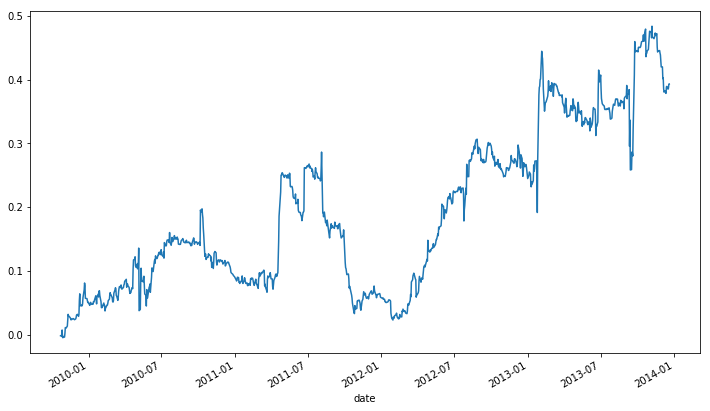

In [30]:
# %% compute perfs
data_perf = datasample.loc[datasample['filter'] == 1].dropna(subset=['signal'])
data_perf['position'] = data_perf.signal.groupby(level=0).apply(lambda x: x - np.mean(x))
data_perf['perf'] = data_perf.position * data_perf.future_perf_1d
data_perf['to'] = data_perf.position.groupby(level=1).diff().fillna(0).abs()
data_perf['not'] = data_perf.position.fillna(0).abs()

# %% perfs
print('Sharpe: ' + "{0:.3f}".format(16 * data_perf.perf.groupby(
    level=0).sum().mean() / data_perf.perf.groupby(level=0).sum().std()))
print('rbt: ' + "{0:.3f}".format(100 * data_perf.perf.groupby(
    level=0).sum().sum() / data_perf.to.groupby(level=0).sum().sum()) + "%")
print('holding: ' + "{0:.2f}".format(2 * data_perf['not'].groupby(
    level=0).sum().sum() / data_perf.to.groupby(level=0).sum().sum()))
data_perf.perf.groupby('date').sum().cumsum().plot(figsize=(12, 7))

# data_computed.loc(axis=0)[:, 'HHS'].reset_index(level=1, drop=True).close.plot(figsize=(16, 7))

Sharpe: 0.793
rbt: 0.016%
holding: 2.89


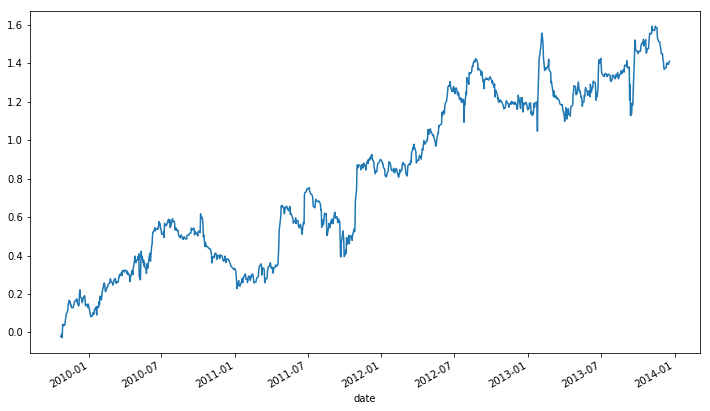

In [31]:
# %% compute perfs
data_perf = mr_signal.data.loc[datasample['filter'] == 1].dropna(subset=['signalReverted'])
data_perf['position'] = data_perf.signalReverted.groupby(level=0).apply(lambda x: x - np.mean(x))
data_perf['perf'] = data_perf.position * data_perf.future_perf_1d
data_perf['to'] = data_perf.position.groupby(level=1).diff().fillna(0).abs()
data_perf['not'] = data_perf.position.fillna(0).abs()

# %% perfs
print('Sharpe: ' + "{0:.3f}".format(16 * data_perf.perf.groupby(
    level=0).sum().mean() / data_perf.perf.groupby(level=0).sum().std()))
print('rbt: ' + "{0:.3f}".format(100 * data_perf.perf.groupby(
    level=0).sum().sum() / data_perf.to.groupby(level=0).sum().sum()) + "%")
print('holding: ' + "{0:.2f}".format(2 * data_perf['not'].groupby(
    level=0).sum().sum() / data_perf.to.groupby(level=0).sum().sum()))
data_perf.perf.groupby('date').sum().cumsum().plot(figsize=(12, 7))

# data_computed.loc(axis=0)[:, 'HHS'].reset_index(level=1, drop=True).close.plot(figsize=(16, 7))